<a href="https://colab.research.google.com/github/AbhiRam36/decisiontree-536/blob/main/decisionTree_536.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mtp
from math import*

In [239]:
import copy
from graphviz import Digraph
import random

Available Datasets:

1.   Weather
2.   Dermotology
3.   Echocardiogram
4.   Ionosphere
5.   Spectf





In [240]:
datasets={'weather':['https://raw.githubusercontent.com/AbhiRam36/decisiontree-536/main/eighthr.data.csv','0'],'dermatology':['https://raw.githubusercontent.com/AbhiRam36/decisiontree-536/main/dermatology.data.csv','2'],'echo':['https://raw.githubusercontent.com/AbhiRam36/decisiontree-536/main/echocardiogram.data.csv','71'],'lymphography':['https://raw.githubusercontent.com/AbhiRam36/decisiontree-536/main/lymph.csv','lymphatics'],'heart':['https://raw.githubusercontent.com/AbhiRam36/decisiontree-536/main/SPECTF.train.csv' ,'1']}

**Implementation of Train Test Split**

---



In [241]:
def train_test_split(df,test_size):
  df=df.sample(frac = 1)
  n=len(df)
  no_test_rows=int(n*test_size)
  l=list(random.sample(list(range(n)), no_test_rows))
  test=df.iloc[l]
  train=df.drop(l,axis=0)
  return train.sample(frac = 1),test.sample(frac = 1)

**Implementation of Accuracy Function**

In [242]:
def accuracy_score(y_true, y_pred):
  total_count=len(y_true)
  correct_prediction_count=0
  for i in range(total_count):
    if y_true[i]==y_pred[i]:
      correct_prediction_count+=1
  return (correct_prediction_count/total_count)*100

**Implementation of Decision Tree Algorithm**

In [243]:
class DecisionTree():
  
  ## Class Member Functions ##

  def entropy_help(p):
    return -p*log(p,2)
  
  def getEntropy(df,target_name):  
    n=df.count()[0]
    target_counts=df[target_name].value_counts().to_dict()
    s=0
    for p in target_counts.values():
      if p/n==1 or p/n==0:
        return 0
      s+=DecisionTree.entropy_help(p/n)
    # print(s)
    return s
  
  def getProbability(df,column,value):
    return df[df[column]==value].count()[0]/df.count()[0]
  
  def informationGain(df,target_name,col):
    # print("Entropy of ",col,DecisionTree.getEntropy(df,target_name))
    total_entropy=DecisionTree.getEntropy(df,target_name)
    col_vals_count=df[col].value_counts().to_dict()
    sum=0
    for value in col_vals_count:
      n=col_vals_count[value]
      # print("Entropy of ",col,value,DecisionTree.getEntropy(df[df[col]==value],target_name))
      sum+=(DecisionTree.getEntropy(df[df[col]==value],target_name)*DecisionTree.getProbability(df,col,value))
    # print("IG: ",target_name,col,total_entropy-sum)
    return total_entropy-sum

  ## Class Data Members ##

  split_functions={'IG':informationGain}
  
  ## Countructor ##
  def __init__(self,df,target_name,split_function="IG",level=-1,leaf_nodes=-1):
    self.tree=self.Tree()
    self.df=df
    self.target_name=target_name
    self.cols=list(self.df.columns)
    self.cols.remove(self.target_name)
    self.cnt=0
    self.gnodes=[]
    self.level=level
    self.leaf_nodes=leaf_nodes
    self.rules=[]
    self.output_classes=self.df[self.target_name].unique()
    if split_function in DecisionTree.split_functions:
      self.split_function=DecisionTree.split_functions[split_function]
    else:
      raise Exception("Split function not found")

  ## Instance Methods ##

  def getGraph(self):
    return self.tree.g

  def find_leaf(self,df):
    counts=df[self.target_name].value_counts().to_dict()
    return max(zip(counts.values(), counts.keys()))[1]
    
      # unique_vals=list(df[self.target_name].unique())
      # for val in unique_vals:      
      #   if df[df[self.target_name]==val].count()[0]==df.count()[0]:
      #     return val

  def construct(self):
    maxig=[-1,""]
    for i in self.cols:
      etemp=self.split_function(df,self.target_name,i)
      maxig=maxig if maxig[0]>etemp else [etemp,i]
    root=self.Node(maxig[1],maxig[0],0)
    self.tree.insert_root(root)
    c=copy.deepcopy(self.cols)
    c.remove(root.name)
    root.gname=str(root)
    self.gnodes.append(root)
    self.tree.g.node(str(root),str(root))
    self.construct_help(df,c,root)

  def construct_help(self,df,cols,parent):
    if not parent.name:
      return
    vals=list(df[parent.name].unique())
    dftemp=df

    for k in vals:
      if self.leaf_nodes!=-1 and self.tree.no_leafs>=self.leaf_nodes:
        return
      df=dftemp
      df=df[df[parent.name]==k]
      e=DecisionTree.getEntropy(df,self.target_name)

      if e==0 or parent.level==self.level-1:
        value=self.find_leaf(df)
        node=self.Node(value,1,parent.level+1)
        node.gname=str(value)
        parent.insert_child(node)
        parent.insert_edge(k)
        self.tree.no_leafs+=1
        name=value
        if not isinstance(value, str):
          name='class'
        self.tree.g.node(name+str(self.cnt),str(value))
        self.tree.g.edge(str(parent.gname),name+str(self.cnt),label=str(k))
        
        self.cnt+=1
        continue
      maxig=[-1,""]
      for i in cols:
        etemp=self.split_function(df,self.target_name,i)
        maxig=maxig if maxig[0]>etemp else [etemp,i]
      node=self.Node(maxig[1],maxig[0],parent.level+1)
      node.gname=str(node.name)
      c=copy.deepcopy(cols)
      if node.name in c:
        c.remove(node.name)
      name=str(node)

      # checking if node name already exist in graphviz code
      
      if name in self.gnodes:
        name+=str(self.cnt)
        self.cnt+=1
      else:
        self.gnodes.append(name)
      node.gname=name

      parent.insert_child(node)
      parent.insert_edge(k)

      self.tree.g.node(name,str(node))
      self.tree.g.edge(str(parent.gname),name,label=str(k))
      
      self.construct_help(df[df[parent.name]==k],c,node)
      
  def predict(self,instances,trace=False):
    node=self.tree.root
    op=[]
    if isinstance(instances,dict):
      return self.predict_help(node,instances,trace,"")
    if isinstance(instances,list):
      
      for instance in instances:
        op.append(self.predict_help(node,instance,trace,""))
    else:
      n=len(instances)
      for i in range(n):
        instance=instances.iloc[i].to_dict()
        op.append(self.predict_help(node,instance,trace,""))
    return op

  def predict_help(self,node,instance,trace,path):
    if node.name in self.output_classes:
      if trace:
        print(path+str(node))
      return node.name
    value=instance[node.name]
    try:
      path+=str(node)+" ( "+str(value)+" ) -> "
      ind=node.edges.index(value)
      return self.predict_help(node.childs[ind],instance,trace,path)
    except Exception as e:
      return "Not valid instance, path: "+path
  def get_rules(self):
    node=self.tree.root
    self.rules_help(node,str(node.name)+" -> ")
    return self.rules

  def rules_help(self,node,path):
    for n,e in zip(node.childs,node.edges):
      if n.name in self.output_classes:
        self.rules.append("{} ( {} ) {}".format(path,str(e),str(n.name)))
      self.rules_help(n,"{} ( {} ) {} -> ".format(path,str(e),str(n.name)))
  
  ## Inner classes ##
  class Node:
    ## Countructor ##
    def __init__(self,name,ig,level):
      self.name=name
      self.ig=ig
      self.childs=[]
      self.edges=[]
      self.gname=''
      self.level=level

    ## Instance Methods ##

    def insert_child(self,node):
      self.childs.append(node)

    def insert_edge(self,edge):
      self.edges.append(edge)

    def printn(self,edge=""):
      # if self.childs:
      dashes="|"+"-"*(self.level*5)
      value="( "+str(edge)+") "+str(self.gname) if edge else str(self.gname)
      # print(" "*(self.level*2+1),''.join(['-']*31))
      # print(dashes,'|{:^15} - level - {:^2} | '.format(self.gname,self.level),list(zip(self.edges,list(map(lambda x:x.gname,self.childs)))))
      # print(" "*(self.level*2+1),''.join(['-']*31))
      print(dashes,value)

    def __str__(self):
      return str(self.name)

  class Tree:

    ## Countructor ##
    def __init__(self):
      self.root=None
      self.g=Digraph(encoding='utf-8')
      self.no_leafs=0

    ## Instance Methods ##

    def insert_root(self,node):
      self.root=node

    def printt(self):
      self.print_help(self.root,"")

    def print_help(self,node,edge):
      if node:
        node.printn(edge)
        # print("(",edge,")")
      for i in range(len(node.childs)):
        self.print_help(node.childs[i],node.edges[i])

**WEATHER DATA SET**

In [244]:
dataset='weather'
split_func='IG'

In [245]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [246]:
data

,1/1/1998,0.8,1.8,2.4,2.1,2,2.1.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.
0,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
1,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
2,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
3,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,?,?,?,?,?,?,?,?,0.58,0.0
4,1/6/1998,3.1,3.5,3.3,2.5,1.6,1.7,1.6,1.6,2.3,...,0.09,11.98,11.28,5770,27.95,46.25,10120,?,5.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2528,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,...,0.07,7.93,-4.41,5800,-25.6,21.8,10295,65,0,0.0
2529,12/28/2004,1,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,...,0.04,5.95,-1.14,5845,-19.4,19.1,10310,15,0,0.0
2530,12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,...,0.06,7.8,-0.64,5845,-9.6,35.2,10275,-35,0,0.0
2531,12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1,1.9,...,0.25,7.72,-0.89,5845,-19.6,34.2,10245,-30,0.05,0.0


In [247]:
data.dtypes

1/1/1998     object
0.8          object
1.8          object
2.4          object
2.1          object
             ...   
17.9         object
10330        object
-55          object
0            object
0.          float64
Length: 74, dtype: object

In [248]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  1774 
 Size of Test Dataset:  759


In [249]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

1/1/1998    1774
0.8         1774
1.8         1774
2.4         1774
2.1         1774
            ... 
17.9        1774
10330       1774
-55         1774
0           1774
0.          1774
Length: 74, dtype: int64
1774


In [250]:
d=DecisionTree(data,target_name,split_function=split_func)

In [251]:
d.construct()

In [252]:
print(d.tree.no_leafs)

1774


In [253]:
d.get_rules()

['1/1/1998 ->  ( 11/20/2004 ) 2.95',
 '1/1/1998 ->  ( 2/17/2004 ) 0',
 '1/1/1998 ->  ( 12/29/2001 ) 0',
 '1/1/1998 ->  ( 9/16/2001 ) 0',
 '1/1/1998 ->  ( 4/19/2004 ) 0',
 '1/1/1998 ->  ( 12/24/2002 ) 0.03',
 '1/1/1998 ->  ( 5/28/2004 ) 0.3',
 '1/1/1998 ->  ( 7/15/1999 ) 0',
 '1/1/1998 ->  ( 9/2/1999 ) 0',
 '1/1/1998 ->  ( 3/28/2001 ) 1.3',
 '1/1/1998 ->  ( 5/4/1998 ) 0',
 '1/1/1998 ->  ( 6/21/1998 ) 0',
 '1/1/1998 ->  ( 4/30/1998 ) 0',
 '1/1/1998 ->  ( 10/7/2004 ) 0.84',
 '1/1/1998 ->  ( 7/15/2002 ) 1.4',
 '1/1/1998 ->  ( 5/5/2003 ) 0',
 '1/1/1998 ->  ( 6/9/2000 ) 1.96',
 '1/1/1998 ->  ( 8/26/2004 ) 0',
 '1/1/1998 ->  ( 6/2/2003 ) 0.05',
 '1/1/1998 ->  ( 11/22/2002 ) 0',
 '1/1/1998 ->  ( 1/22/2000 ) 0',
 '1/1/1998 ->  ( 11/12/1999 ) 0',
 '1/1/1998 ->  ( 10/17/2002 ) 0',
 '1/1/1998 ->  ( 10/11/2002 ) 0',
 '1/1/1998 ->  ( 4/6/2003 ) 0.08',
 '1/1/1998 ->  ( 7/12/2003 ) 0',
 '1/1/1998 ->  ( 8/30/2001 ) 2.39',
 '1/1/1998 ->  ( 3/25/1999 ) 0',
 '1/1/1998 ->  ( 1/25/2002 ) 0',
 '1/1/1998 ->  

In [254]:
d.tree.printt()

| 1/1/1998
|----- ( 11/20/2004) 2.95
|----- ( 2/17/2004) 0
|----- ( 12/29/2001) 0
|----- ( 9/16/2001) 0
|----- ( 4/19/2004) 0
|----- ( 12/24/2002) 0.03
|----- ( 5/28/2004) 0.3
|----- ( 7/15/1999) 0
|----- ( 9/2/1999) 0
|----- ( 3/28/2001) 1.3
|----- ( 5/4/1998) 0
|----- ( 6/21/1998) 0
|----- ( 4/30/1998) 0
|----- ( 10/7/2004) 0.84
|----- ( 7/15/2002) 1.4
|----- ( 5/5/2003) 0
|----- ( 6/9/2000) 1.96
|----- ( 8/26/2004) 0
|----- ( 6/2/2003) 0.05
|----- ( 11/22/2002) 0
|----- ( 1/22/2000) 0
|----- ( 11/12/1999) 0
|----- ( 10/17/2002) 0
|----- ( 10/11/2002) 0
|----- ( 4/6/2003) 0.08
|----- ( 7/12/2003) 0
|----- ( 8/30/2001) 2.39
|----- ( 3/25/1999) 0
|----- ( 1/25/2002) 0
|----- ( 3/27/2000) 0
|----- ( 1/21/1999) 0
|----- ( 10/24/2001) 0
|----- ( 7/3/2004) 0
|----- ( 10/18/2001) 0
|----- ( 7/11/1998) 0
|----- ( 1/16/1999) 0
|----- ( 12/30/2002) 1.68
|----- ( 8/30/2000) 0
|----- ( 8/28/1998) 0
|----- ( 1/27/2000) 2.18
|----- ( 12/7/2003) 0
|----- ( 9/5/2001) 4.65
|----- ( 11/15/2001) 0
|---

In [255]:
f = open("weather.dot", "w")
f.write(str(d.getGraph()))
f.close()

In [256]:
d.getGraph()

In [257]:
df

,1/1/1998,0.8,1.8,2.4,2.1,2,2.1.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.
2491,11/20/2004,1.8,1.6,2.2,2.6,2.5,2.4,2.8,1.6,2,...,0.31,16.26,4.77,5810,27.15,41.15,10155,-10,2.95,0.0
2214,2/17/2004,1.1,0.4,0.1,0.9,0.4,0.3,1.1,2.4,2.5,...,0.25,?,?,5680,10.2,41.9,10260,25,0,0.0
1444,12/29/2001,0.1,0.1,0,0.2,0.1,0.1,0.4,0.3,0.5,...,0.17,21.56,-4.76,5695,-29.3,22.3,10120,-10,0,0.0
1340,9/16/2001,0.2,0.2,0,0.4,0.6,0.5,0.2,0.5,0.7,...,0.56,6.63,-2.79,5865,24.45,41.35,10140,0,0,1.0
2276,4/19/2004,2.8,2.4,2.1,1.9,1.6,1.7,1.9,3,3.9,...,0.08,5.29,2.19,5905,-30.4,17.3,10250,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,12/22/1998,5.7,6.3,6.1,6,6,6,5.8,5.9,4.9,...,0.32,19.47,9.17,5855,21.3,44.7,10225,15,0.03,0.0
2527,12/26/2004,0.9,0.4,0.3,0.2,0.3,0.2,0.3,0.3,0.3,...,0.13,8.77,-11.98,5670,-6.6,25.5,10230,10,0,0.0
1844,2/11/2003,?,?,?,?,?,?,?,?,?,...,0.38,?,?,5740,-39.6,12.8,10210,60,0,0.0
687,12/2/1999,1.7,1.2,0.7,1.3,2.2,2.7,2.3,2.3,3.8,...,0.07,5.46,2.14,5825,-13.9,22.4,10250,-65,1.07,0.0


In [258]:
y_train_pred=d.predict(df)
print(y_train_pred)
print(df[target_name])
print(accuracy_score(df[target_name].tolist(),y_train_pred))

['2.95', '0', '0', '0', '0', '0.03', '0.3', '0', '0', '1.3', '0', '0', '0', '0.84', '1.4', '0', '1.96', '0', '0.05', '0', '0', '0', '0', '0', '0.08', '0', '2.39', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1.68', '0', '0', '2.18', '0', '4.65', '0', '0', '0', '0', '0', '0', '0.03', '0', '0', '0', '0', '0', '2.08', '0', '0', '0', '0', '6.96', '0', '0', '0', '0', '0', '0', '0', '0.1', '4.24', '0', '0', '0', '0', '9.09', '0', '0', '0', '0', '5.64', '0', '5.11', '0.05', '0', '0', '0', '0', '5.38', '0', '0', '0', '0', '2.69', '6.22', '0', '2.79', '0', '0', '0', '0.03', '0.71', '0', '0.05', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1.68', '0', '0', '0', '0.05', '0', '0.08', '0', '0', '0.03', '0', '1.04', '0', '0', '0.08', '1.52', '0', '0', '0', '1.24', '0', '0', '0', '0.43', '2.31', '0', '0', '0.03', '0', '5.72', '0', '0', '0', '0', '0', '2.11', '0', '0', '0', '0.15', '0', '0', '0', '0', '0.03', '0', '0', '13.54', '5', '0', '0', '1.3', '0', '0', '0.03', '0', '0.05', '0.53', '2.21', '0'

In [259]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

68.11594202898551

**DERMOTOLOGY DATA SET**

In [260]:
dataset='dermatology'
split_func='IG'

In [261]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [262]:
data

,2,2.1,0,3,0.1,0.2,0.3,0.4,1,0.5,...,0.19,0.20,3.2,0.21,0.22,0.23,1.1,0.24,55,2.3
0,3,3,3,2,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,8,1
1,2,1,2,3,1,3,0,3,0,0,...,0,2,3,2,0,0,2,3,26,3
2,2,2,2,0,0,0,0,0,3,2,...,3,0,0,0,0,0,3,0,40,1
3,2,3,2,2,2,2,0,2,0,0,...,2,3,2,3,0,0,2,3,45,3
4,2,3,2,0,0,0,0,0,0,0,...,0,0,2,0,0,0,1,0,41,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2,1,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,2,0,25,4
361,3,2,1,0,1,0,0,0,0,0,...,1,0,1,0,0,0,2,0,36,4
362,3,2,2,2,3,2,0,2,0,0,...,0,3,0,3,0,0,2,3,28,3
363,2,1,3,1,2,3,0,2,0,0,...,0,2,0,1,0,0,2,3,50,3


In [263]:
data.dtypes

2        int64
2.1      int64
0        int64
3        int64
0.1      int64
0.2      int64
0.3      int64
0.4      int64
1        int64
0.5      int64
0.6      int64
0.7      int64
0.8      int64
0.9      int64
0.10     int64
3.1      int64
2.2      int64
0.11     int64
0.12     int64
0.13     int64
0.14     int64
0.15     int64
0.16     int64
0.17     int64
0.18     int64
0.19     int64
0.20     int64
3.2      int64
0.21     int64
0.22     int64
0.23     int64
1.1      int64
0.24     int64
55      object
2.3      int64
dtype: object

In [264]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  256 
 Size of Test Dataset:  109


In [265]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

2       256
2.1     256
0       256
3       256
0.1     256
0.2     256
0.3     256
0.4     256
1       256
0.5     256
0.6     256
0.7     256
0.8     256
0.9     256
0.10    256
3.1     256
2.2     256
0.11    256
0.12    256
0.13    256
0.14    256
0.15    256
0.16    256
0.17    256
0.18    256
0.19    256
0.20    256
3.2     256
0.21    256
0.22    256
0.23    256
1.1     256
0.24    256
55      256
2.3     256
dtype: int64
256


In [266]:
d=DecisionTree(data,target_name,split_function=split_func)

In [267]:
d.construct()

In [268]:
print(d.tree.no_leafs)

166


In [269]:
d.get_rules()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


['55 ->  ( 7 ) 3.2 ->  ( 3 ) 2',
 '55 ->  ( 7 ) 3.2 ->  ( 2 ) 2',
 '55 ->  ( 7 ) 3.2 ->  ( 0 ) 1',
 '55 ->  ( 45 ) 2.3 ->  ( 5 ) 1',
 '55 ->  ( 45 ) 2.3 ->  ( 2 ) 2',
 '55 ->  ( 45 ) 2.3 ->  ( 4 ) 3',
 '55 ->  ( 35 ) 2.3 ->  ( 5 ) 1',
 '55 ->  ( 35 ) 2.3 ->  ( 4 ) 0.21 ->  ( 1 ) 1',
 '55 ->  ( 35 ) 2.3 ->  ( 4 ) 0.21 ->  ( 0 ) 2',
 '55 ->  ( 35 ) 2.3 ->  ( 1 ) 3',
 '55 ->  ( 35 ) 2.3 ->  ( 2 ) 2',
 '55 ->  ( 40 ) 0.12 ->  ( 2 ) 2',
 '55 ->  ( 40 ) 0.12 ->  ( 1 ) 1.1 ->  ( 3 ) 2',
 '55 ->  ( 40 ) 0.12 ->  ( 1 ) 1.1 ->  ( 2 ) 3',
 '55 ->  ( 40 ) 0.12 ->  ( 1 ) 1.1 ->  ( 1 ) 2',
 '55 ->  ( 40 ) 0.12 ->  ( 3 ) 3',
 '55 ->  ( 40 ) 0.12 ->  ( 0 ) 2',
 '55 ->  ( 9 ) 2',
 '55 ->  ( 22 ) 0 ->  ( 0 ) 2',
 '55 ->  ( 22 ) 0 ->  ( 1 ) 1.1 ->  ( 1 ) 3',
 '55 ->  ( 22 ) 0 ->  ( 1 ) 1.1 ->  ( 2 ) 2',
 '55 ->  ( 22 ) 0 ->  ( 3 ) 2',
 '55 ->  ( 22 ) 0 ->  ( 2 ) 3',
 '55 ->  ( 34 ) 2.3 ->  ( 1 ) 2',
 '55 ->  ( 34 ) 2.3 ->  ( 4 ) 2',
 '55 ->  ( 34 ) 2.3 ->  ( 2 ) 1.1 ->  ( 1 ) 2',
 '55 ->  ( 34 ) 2.3 ->  

In [270]:
d.tree.printt()

| 55
|----- ( 7) 3.2
|---------- ( 3) 2
|---------- ( 2) 2
|---------- 1
|----- ( 45) 2.3
|---------- ( 5) 1
|---------- ( 2) 2
|---------- ( 4) 3
|----- ( 35) 2.36
|---------- ( 5) 1
|---------- ( 4) 0.21
|--------------- ( 1) 1
|--------------- 2
|---------- ( 1) 3
|---------- ( 2) 2
|----- ( 40) 0.12
|---------- ( 2) 2
|---------- ( 1) 1.1
|--------------- ( 3) 2
|--------------- ( 2) 3
|--------------- ( 1) 2
|---------- ( 3) 3
|---------- 2
|----- ( 9) 2
|----- ( 22) 0
|---------- 2
|---------- ( 1) 1.120
|--------------- ( 1) 3
|--------------- ( 2) 2
|---------- ( 3) 2
|---------- ( 2) 3
|----- ( 34) 2.325
|---------- ( 1) 2
|---------- ( 4) 2
|---------- ( 2) 1.128
|--------------- ( 1) 2
|--------------- ( 2) 1
|---------- ( 5) 3
|----- ( 10) 0.22
|---------- 2.332
|--------------- ( 2) 3
|--------------- ( 1) 2
|---------- ( 2) 1
|---------- ( 1) 2
|---------- ( 3) 3
|----- ( 51) 2.338
|---------- ( 2) 3
|---------- ( 1) 2
|----- ( 57) 2
|----- ( 27) 042
|---------- ( 1) 2
|-

In [271]:
f = open("dermatology.dot", "w")
f.write(str(d.getGraph()))
f.close()

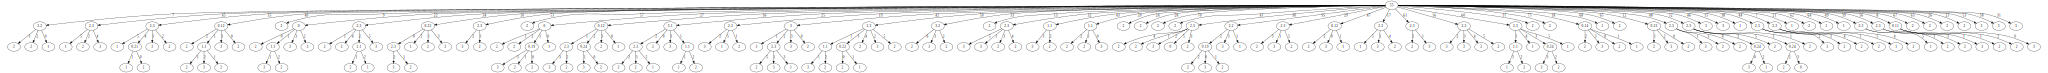

In [272]:
d.getGraph()

In [273]:
df

,2,2.1,0,3,0.1,0.2,0.3,0.4,1,0.5,...,0.19,0.20,3.2,0.21,0.22,0.23,1.1,0.24,55,2.3
348,2,2,1,0,0,0,2,0,2,0,...,0,0,3,0,2,2,2,0,7,6
352,1,1,1,2,0,0,0,0,0,0,...,0,0,1,0,0,0,2,0,45,5
183,2,2,1,0,0,0,3,0,2,0,...,0,0,2,0,3,3,2,0,7,6
225,1,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,35,5
60,2,1,1,0,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,2,1,3,3,3,3,0,0,2,0,...,0,2,0,3,0,0,2,3,23,3
290,2,2,2,0,1,0,0,0,1,1,...,1,0,0,0,0,0,2,0,42,1
187,3,2,0,2,0,0,0,0,0,0,...,0,0,3,0,0,0,3,0,55,2
298,2,2,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,52,5


In [274]:
y_train_pred=d.predict(df)
print(y_train_pred)
print(df[target_name])
print(accuracy_score(df[target_name].tolist(),y_train_pred))

[2, 1, 2, 1, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 2, 2, 3, 1, 2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 3, 1, 2, 2, 3, 2, 2, 3, 3, 1, 2, 3, 3, 1, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 2, 3, 2, 3, 2, 2, 2, 2, 1, 3, 2, 2, 1, 2, 1, 2, 3, 2, 1, 3, 2, 3, 3, 1, 1, 2, 2, 2, 3, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 1, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 1, 1, 2, 2, 3, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 1, 2, 3, 2, 1, 2, 2, 1, 2, 2, 1, 3, 1, 2, 2, 2, 3, 2, 2, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2]
348    2
352    1
183    2
225    1
60     2
      ..
17     2
290    2
187    3
298    2
174    2
Name: 2, Length: 256, dtype: int64
100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [275]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


77.98165137614679

**ECHOCARDIOGRAM DATASET**

In [276]:
dataset='echo'
split_func='IG'

In [277]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url,error_bad_lines=False)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 50: expected 13 fields, saw 14\n'


In [278]:
data

,11,0,71,0.1,0.260,9,4.600,14,1,1.1,name,1.2,0.2
0,19,0,72,0,0.380,6,4.100,14,1.700,0.588,name,1,0
1,16,0,55,0,0.260,4,3.420,14,1,1,name,1,0
2,57,0,60,0,0.253,12.062,4.603,16,1.450,0.788,name,1,0
3,19,1,57,0,0.160,22,5.750,18,2.250,0.571,name,1,0
4,26,0,68,0,0.260,5,4.310,12,1,0.857,name,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,7.5,1,64,0,0.24,12.9,4.72,12,1,0.857,name,?,?
126,41,0,64,0,0.28,5.40,5.47,11,1.10,0.714,name,?,?
127,36,0,69,0,0.20,7.00,5.05,14.5,1.21,0.857,name,?,?
128,22,0,57,0,0.14,16.1,4.36,15,1.36,0.786,name,?,?


In [279]:
data.dtypes

11       object
0         int64
71       object
0.1       int64
0.260    object
9        object
4.600    object
14       object
1        object
1.1      object
name     object
1.2      object
0.2      object
dtype: object

In [280]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  91 
 Size of Test Dataset:  39


In [281]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

11       91
0        91
71       91
0.1      91
0.260    91
9        91
4.600    91
14       91
1        91
1.1      91
name     91
1.2      91
0.2      91
dtype: int64
91


In [282]:
d=DecisionTree(data,target_name,split_function=split_func)

In [283]:
d.construct()

In [284]:
print(d.tree.no_leafs)

91


In [285]:
d.get_rules()

['4.600 ->  ( 5.49 ) 0.2 ->  ( ? ) ?',
 '4.600 ->  ( 5.49 ) 0.2 ->  ( 0 ) 59',
 '4.600 ->  ( 3.87 ) 63',
 '4.600 ->  ( 3.420 ) 55',
 '4.600 ->  ( 5.15 ) 79',
 '4.600 ->  ( 3.480 ) 64',
 '4.600 ->  ( 5.26 ) 51',
 '4.600 ->  ( 4.650 ) 1.1 ->  ( 0.784 ) 69',
 '4.600 ->  ( 4.650 ) 1.1 ->  ( 0.570 ) 71',
 '4.600 ->  ( 4.54 ) 54',
 '4.600 ->  ( 3.880 ) 68',
 '4.600 ->  ( 3.730 ) 60',
 '4.600 ->  ( 5.460 ) 85',
 '4.600 ->  ( 4.31 ) 60',
 '4.600 ->  ( 4.230 ) 77',
 '4.600 ->  ( 3.100 ) 47',
 '4.600 ->  ( 6.290 ) 59',
 '4.600 ->  ( 5.05 ) 69',
 '4.600 ->  ( 5.650 ) 60',
 '4.600 ->  ( 6.150 ) 66',
 '4.600 ->  ( ? ) 14 ->  ( 21.500 ) 65',
 '4.600 ->  ( ? ) 14 ->  ( 2 ) 55',
 '4.600 ->  ( ? ) 14 ->  ( ? ) 75',
 '4.600 ->  ( ? ) 14 ->  ( 6 ) ?',
 '4.600 ->  ( ? ) 14 ->  ( 9 ) 81',
 '4.600 ->  ( ? ) 14 ->  ( 23 ) 63',
 '4.600 ->  ( 4.96 ) 1.2 ->  ( ? ) ?',
 '4.600 ->  ( 4.96 ) 1.2 ->  ( 2 ) 59',
 '4.600 ->  ( 4.100 ) 72',
 '4.600 ->  ( 5.800 ) 62',
 '4.600 ->  ( 5.47 ) 0.2 ->  ( ? ) 64',
 '4.600 -> 

In [286]:
d.tree.printt()

| 4.600
|----- ( 5.49) 0.2
|---------- ( ?) ?
|---------- ( 0) 59
|----- ( 3.87) 63
|----- ( 3.420) 55
|----- ( 5.15) 79
|----- ( 3.480) 64
|----- ( 5.26) 51
|----- ( 4.650) 1.1
|---------- ( 0.784) 69
|---------- ( 0.570) 71
|----- ( 4.54) 54
|----- ( 3.880) 68
|----- ( 3.730) 60
|----- ( 5.460) 85
|----- ( 4.31) 60
|----- ( 4.230) 77
|----- ( 3.100) 47
|----- ( 6.290) 59
|----- ( 5.05) 69
|----- ( 5.650) 60
|----- ( 6.150) 66
|----- ( ?) 14
|---------- ( 21.500) 65
|---------- ( 2) 55
|---------- ( ?) 75
|---------- ( 6) ?
|---------- ( 9) 81
|---------- ( 23) 63
|----- ( 4.96) 1.2
|---------- ( ?) ?
|---------- ( 2) 59
|----- ( 4.100) 72
|----- ( 5.800) 62
|----- ( 5.47) 0.230
|---------- ( ?) 64
|---------- ( 1) 65
|----- ( 6.63) 62
|----- ( 4.69) 53
|----- ( 5.320) 52
|----- ( 5.20) 0.236
|---------- ( 1) 86
|---------- ( ?) 63
|----- ( 4.48) 0.239
|---------- ( 0) 55
|---------- ( ?) 62
|----- ( 3.630) 54
|----- ( 4.29) 57
|----- ( 4.17) 64
|----- ( 5.050) 65
|----- ( 3.52) 63
|-

In [287]:
f = open("echo.dot", "w")
f.write(str(d.getGraph()))
f.close()

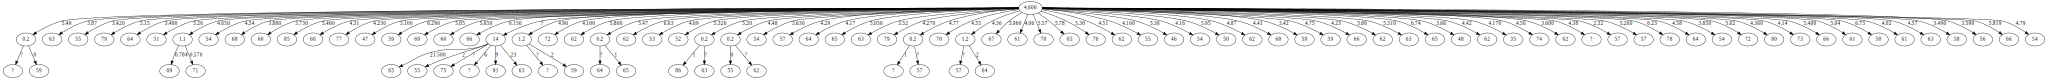

In [288]:
d.getGraph()

In [289]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


In [290]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

61.53846153846154

**IONOSPHERE DATASET**

In [291]:
dataset='lymphography'
split_func='IG'

In [292]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [293]:
data

,lymphatics,block_of_affere,bl_of_lymph_c,bl_of_lymph_s,by_pass,extravasates,regeneration_of,early_uptake_in,lym_nodes_dimin,lym_nodes_enlar,changes_in_lym,defect_in_node,changes_in_node,changes_in_stru,special_forms,dislocation_of,exclusion_of_no,no_of_nodes_in,class
0,arched,yes,no,no,no,no,no,yes,1,4,round,lac_central,lacunar,stripped,vesicles,yes,yes,5,malign_lymph
1,displaced,yes,no,no,yes,yes,no,yes,1,3,round,lac_central,lacunar,diluted,vesicles,yes,yes,3,malign_lymph
2,deformed,no,no,no,yes,yes,yes,no,3,1,bean,lacunar,no,diluted,vesicles,no,no,7,fibrosis
3,arched,no,no,no,no,yes,no,yes,1,2,oval,lac_margin,lac_margin,drop_like,vesicles,no,yes,1,malign_lymph
4,arched,no,no,no,no,no,no,no,1,2,round,lac_margin,lac_margin,faint,vesicles,no,no,1,metastases
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,displaced,no,no,no,no,no,no,yes,1,3,round,lacunar,lacunar,coarse,chalices,yes,yes,2,metastases
144,deformed,no,no,no,no,yes,no,yes,1,4,round,lac_central,lacunar,coarse,vesicles,yes,yes,6,malign_lymph
145,deformed,yes,no,no,yes,yes,no,yes,1,2,oval,lac_central,lac_margin,diluted,chalices,yes,yes,4,malign_lymph
146,deformed,yes,no,no,no,no,no,yes,1,3,oval,lacunar,lac_central,faint,vesicles,yes,yes,3,malign_lymph


In [294]:
data.dtypes

lymphatics         object
block_of_affere    object
bl_of_lymph_c      object
bl_of_lymph_s      object
by_pass            object
extravasates       object
regeneration_of    object
early_uptake_in    object
lym_nodes_dimin     int64
lym_nodes_enlar     int64
changes_in_lym     object
defect_in_node     object
changes_in_node    object
changes_in_stru    object
special_forms      object
dislocation_of     object
exclusion_of_no    object
no_of_nodes_in      int64
class              object
dtype: object

In [295]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  104 
 Size of Test Dataset:  44


In [296]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

lymphatics         104
block_of_affere    104
bl_of_lymph_c      104
bl_of_lymph_s      104
by_pass            104
extravasates       104
regeneration_of    104
early_uptake_in    104
lym_nodes_dimin    104
lym_nodes_enlar    104
changes_in_lym     104
defect_in_node     104
changes_in_node    104
changes_in_stru    104
special_forms      104
dislocation_of     104
exclusion_of_no    104
no_of_nodes_in     104
class              104
dtype: int64
104


In [297]:
d=DecisionTree(data,target_name,split_function=split_func)

In [298]:
d.construct()

In [299]:
print(d.tree.no_leafs)

72


In [300]:
d.get_rules()

['changes_in_stru ->  ( stripped ) changes_in_node ->  ( lacunar ) arched',
 'changes_in_stru ->  ( stripped ) changes_in_node ->  ( lac_margin ) displaced',
 'changes_in_stru ->  ( stripped ) changes_in_node ->  ( lac_central ) displaced',
 'changes_in_stru ->  ( stripped ) changes_in_node ->  ( no ) arched',
 'changes_in_stru ->  ( coarse ) no_of_nodes_in ->  ( 2 ) lym_nodes_enlar ->  ( 3 ) changes_in_lym ->  ( round ) special_forms ->  ( chalices ) changes_in_node ->  ( lacunar ) displaced',
 'changes_in_stru ->  ( coarse ) no_of_nodes_in ->  ( 2 ) lym_nodes_enlar ->  ( 3 ) changes_in_lym ->  ( round ) special_forms ->  ( chalices ) changes_in_node ->  ( lac_margin ) deformed',
 'changes_in_stru ->  ( coarse ) no_of_nodes_in ->  ( 2 ) lym_nodes_enlar ->  ( 3 ) changes_in_lym ->  ( round ) special_forms ->  ( vesicles ) displaced',
 'changes_in_stru ->  ( coarse ) no_of_nodes_in ->  ( 2 ) lym_nodes_enlar ->  ( 3 ) changes_in_lym ->  ( oval ) deformed',
 'changes_in_stru ->  ( coarse 

In [301]:
d.tree.printt()

| changes_in_stru
|----- ( stripped) changes_in_node
|---------- ( lacunar) arched
|---------- ( lac_margin) displaced
|---------- ( lac_central) displaced
|---------- ( no) arched
|----- ( coarse) no_of_nodes_in
|---------- ( 2) lym_nodes_enlar
|--------------- ( 3) changes_in_lym
|-------------------- ( round) special_forms
|------------------------- ( chalices) changes_in_node4
|------------------------------ ( lacunar) displaced
|------------------------------ ( lac_margin) deformed
|------------------------- ( vesicles) displaced
|-------------------- ( oval) deformed
|--------------- ( 2) exclusion_of_no
|-------------------- ( yes) deformed
|-------------------- ( no) arched
|--------------- ( 4) displaced
|---------- ( 1) special_forms12
|--------------- ( no) deformed
|--------------- ( chalices) exclusion_of_no14
|-------------------- ( yes) arched
|-------------------- ( no) displaced
|---------- ( 7) deformed
|---------- ( 6) changes_in_node18
|--------------- ( lacunar) de

In [302]:
f = open("lymphography.dot", "w")
f.write(str(d.getGraph()))
f.close()

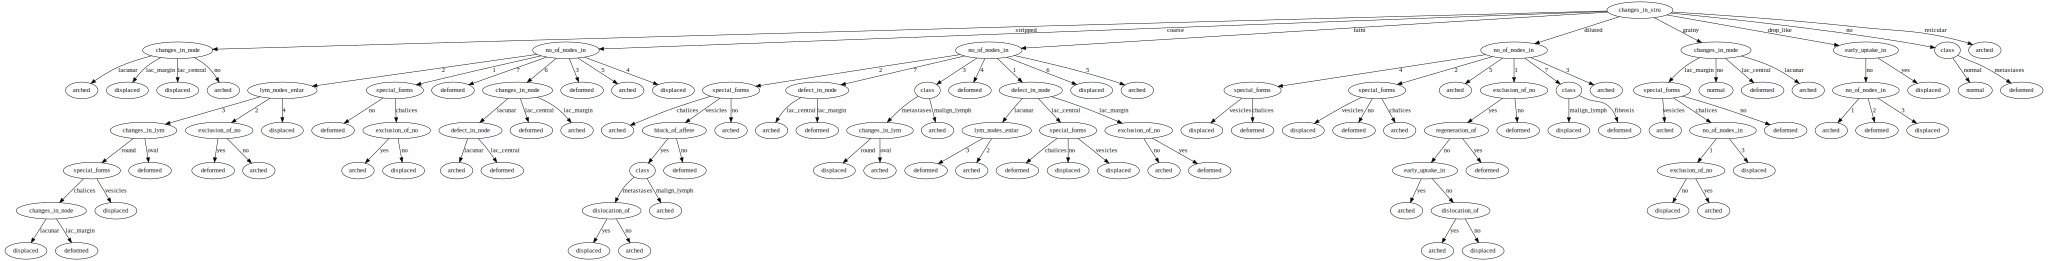

In [303]:
d.getGraph()

In [304]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


In [305]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

86.36363636363636

**SPECTF HEART DATASET**

In [306]:
dataset='heart'
split_func='IG'

In [307]:
dataset_url,target_name=datasets[dataset]
data=pd.read_csv(dataset_url)
data=data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [308]:
data

,1,59,52,70,67,73,66,72,61,58,...,66.3,56.1,62,56.2,72.3,62.1,74.2,74.3,64.1,67.4
0,1,72,62,69,67,78,82,74,65,69,...,65,71,63,60,69,73,67,71,56,58
1,1,71,62,70,64,67,64,79,65,70,...,73,70,66,65,64,55,61,41,51,46
2,1,69,71,70,78,61,63,67,65,59,...,61,61,66,65,72,73,68,68,59,63
3,1,70,66,61,66,61,58,69,69,72,...,67,69,70,66,70,64,60,55,49,41
4,1,57,69,68,75,69,74,73,71,57,...,63,58,69,67,79,77,72,70,61,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0,70,75,72,72,67,71,71,78,63,...,66,67,68,70,70,71,64,67,56,54
75,0,59,57,67,71,66,68,68,70,56,...,62,64,56,53,71,68,64,63,56,56
76,0,67,64,73,75,77,77,74,70,65,...,61,64,65,60,68,75,74,80,67,68
77,0,68,65,72,72,47,74,76,74,67,...,64,69,71,73,73,75,68,56,58,44


In [309]:
data.dtypes

1       int64
59      int64
52      int64
70      int64
67      int64
73      int64
66      int64
72      int64
61      int64
58      int64
52.1    int64
72.1    int64
71      int64
70.1    int64
77      int64
66.1    int64
65      int64
67.1    int64
55      int64
61.1    int64
57      int64
68      int64
66.2    int64
72.2    int64
74      int64
63      int64
64      int64
56      int64
54      int64
67.2    int64
54.1    int64
76      int64
74.1    int64
65.1    int64
67.3    int64
66.3    int64
56.1    int64
62      int64
56.2    int64
72.3    int64
62.1    int64
74.2    int64
74.3    int64
64.1    int64
67.4    int64
dtype: object

In [310]:
df,test_df=train_test_split(data,0.3)
print("Size of Train Dataset: ",len(df),"\n","Size of Test Dataset: ",len(test_df))

Size of Train Dataset:  56 
 Size of Test Dataset:  23


In [311]:
print(df.count())
print(sum(df[target_name].value_counts().to_dict().values()))

1       56
59      56
52      56
70      56
67      56
73      56
66      56
72      56
61      56
58      56
52.1    56
72.1    56
71      56
70.1    56
77      56
66.1    56
65      56
67.1    56
55      56
61.1    56
57      56
68      56
66.2    56
72.2    56
74      56
63      56
64      56
56      56
54      56
67.2    56
54.1    56
76      56
74.1    56
65.1    56
67.3    56
66.3    56
56.1    56
62      56
56.2    56
72.3    56
62.1    56
74.2    56
74.3    56
64.1    56
67.4    56
dtype: int64
56


In [312]:
d=DecisionTree(data,target_name,split_function=split_func)

In [313]:
d.construct()

In [314]:
print(d.tree.no_leafs)

42


In [315]:
d.get_rules()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:175: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


['64 ->  ( 62 ) 0',
 '64 ->  ( 71 ) 67.4 ->  ( 73 ) 1',
 '64 ->  ( 71 ) 67.4 ->  ( 63 ) 1',
 '64 ->  ( 71 ) 67.4 ->  ( 49 ) 0',
 '64 ->  ( 71 ) 67.4 ->  ( 68 ) 0',
 '64 ->  ( 66 ) 0',
 '64 ->  ( 44 ) 1',
 '64 ->  ( 26 ) 1',
 '64 ->  ( 68 ) 0',
 '64 ->  ( 36 ) 1',
 '64 ->  ( 70 ) 67.4 ->  ( 57 ) 0',
 '64 ->  ( 70 ) 67.4 ->  ( 58 ) 0',
 '64 ->  ( 70 ) 67.4 ->  ( 67 ) 1',
 '64 ->  ( 58 ) 0',
 '64 ->  ( 69 ) 67.4 ->  ( 60 ) 0',
 '64 ->  ( 69 ) 67.4 ->  ( 58 ) 1',
 '64 ->  ( 69 ) 67.4 ->  ( 64 ) 0',
 '64 ->  ( 60 ) 67.4 ->  ( 54 ) 0',
 '64 ->  ( 60 ) 67.4 ->  ( 63 ) 1',
 '64 ->  ( 61 ) 0',
 '64 ->  ( 64 ) 0',
 '64 ->  ( 37 ) 1',
 '64 ->  ( 57 ) 67.4 ->  ( 65 ) 0',
 '64 ->  ( 57 ) 67.4 ->  ( 59 ) 1',
 '64 ->  ( 79 ) 0',
 '64 ->  ( 72 ) 1',
 '64 ->  ( 54 ) 1',
 '64 ->  ( 65 ) 74.3 ->  ( 65 ) 0',
 '64 ->  ( 65 ) 74.3 ->  ( 74 ) 0',
 '64 ->  ( 65 ) 74.3 ->  ( 70 ) 1',
 '64 ->  ( 30 ) 1',
 '64 ->  ( 75 ) 1',
 '64 ->  ( 77 ) 0',
 '64 ->  ( 63 ) 67.4 ->  ( 65 ) 1',
 '64 ->  ( 63 ) 67.4 ->  ( 59 ) 

In [316]:
d.tree.printt()

| 64
|----- ( 62) 0
|----- ( 71) 67.4
|---------- ( 73) 1
|---------- ( 63) 1
|---------- ( 49) 0
|---------- ( 68) 0
|----- ( 66) 0
|----- ( 44) 1
|----- ( 26) 1
|----- ( 68) 0
|----- ( 36) 1
|----- ( 70) 67.410
|---------- ( 57) 0
|---------- ( 58) 0
|---------- ( 67) 1
|----- ( 58) 0
|----- ( 69) 67.415
|---------- ( 60) 0
|---------- ( 58) 1
|---------- ( 64) 0
|----- ( 60) 67.419
|---------- ( 54) 0
|---------- ( 63) 1
|----- ( 61) 0
|----- ( 64) 0
|----- ( 37) 1
|----- ( 57) 67.425
|---------- ( 65) 0
|---------- ( 59) 1
|----- ( 79) 0
|----- ( 72) 1
|----- ( 54) 1
|----- ( 65) 74.3
|---------- ( 65) 0
|---------- ( 74) 0
|---------- ( 70) 1
|----- ( 30) 1
|----- ( 75) 1
|----- ( 77) 0
|----- ( 63) 67.437
|---------- ( 65) 1
|---------- ( 59) 0
|----- ( 53) 1
|----- ( 14) 1
|----- ( 76) 1
|----- ( 47) 1
|----- ( 38) 1
|----- ( 73) 0
|----- ( 55) 1


In [317]:
f = open("heart.dot", "w")
f.write(str(d.getGraph()))
f.close()

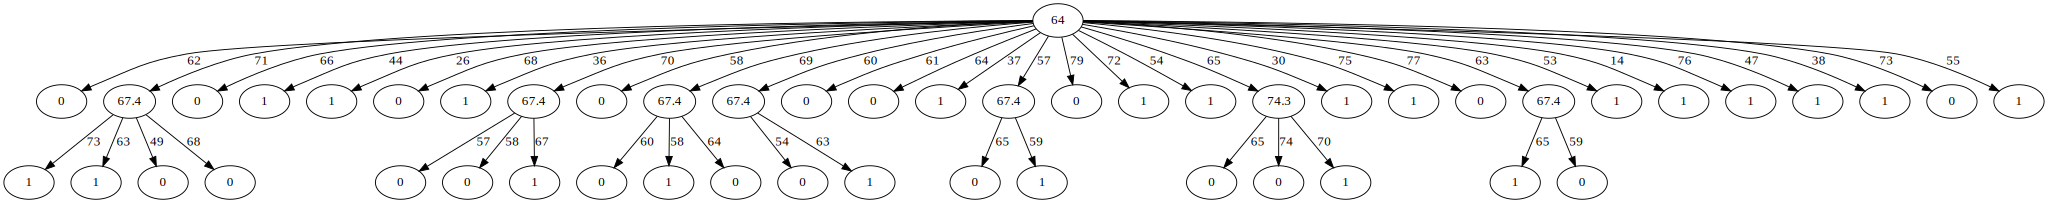

In [318]:
d.getGraph()

In [319]:
y_train_pred=d.predict(df)
print(accuracy_score(df[target_name].tolist(),y_train_pred))

100.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [320]:
y_test_pred=d.predict(test_df)
accuracy_score(test_df[target_name].tolist(),y_test_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


78.26086956521739